## KOmbinovani model 40% originalnog skupa

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import random
from PIL import Image

In [2]:
casting_data_path = '../data_set'
casting_data_train_path = os.path.join(casting_data_path, 'train')
casting_data_test_path = os.path.join(casting_data_path, 'test')
generated_data_path = '../../generated_images3'

### Definišemo transformacije za pripremu podataka

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Promenite veličinu slike na 128x128 piksela
    transforms.ToTensor(),  # Pretvaramo slike u tenzore
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizacija
])

In [4]:
original_dataset = ImageFolder(root=casting_data_train_path, transform=transform)
generated_dataset = ImageFolder(root=generated_data_path, transform=transform)


Uzimamo 40% originalno data set-a

In [5]:
num_original = len(original_dataset)
indices = list(range(num_original))
random.shuffle(indices)
num_original_subset = int(0.4 * num_original)
original_subset_indices = indices[:num_original_subset]

Podskup originalnog data seta sa 40% slika

In [6]:
original_subset = Subset(original_dataset, original_subset_indices)


Kombinovanje originalnih i generisanih slika

In [7]:
combined_dataset = ConcatDataset([original_subset, generated_dataset])



### Podela spojenog seta nas validaciju i trening


In [8]:
num_combined = len(combined_dataset)
num_val_combined = int(0.2 * num_combined)
train_dataset, val_dataset = random_split(combined_dataset, [num_combined - num_val_combined, num_val_combined])

In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=ImageFolder(root=casting_data_test_path, transform=transform), batch_size=32, shuffle=False)


In [10]:
num_test_images = len(test_loader.dataset)
print(f'Number of images in test set: {num_test_images}')

Number of images in test set: 20


In [11]:
model = models.resnet18(pretrained=True)


/home/teki/Documents/sd3/.master/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/teki/Documents/sd3/.master/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:

# Prilagođavanje poslednjeg sloja za našu klasifikaciju
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 klase: 'ok' i 'defekt'

In [13]:
# Provera dostupnosti CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Definisanje funkcije greske i optimizatora


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Treniranje modela

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []  

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoha {epoch+1}/{num_epochs}, Trening greska: {epoch_loss:.4f}, Validaciona greska: {val_loss:.4f}, '
              f'Trening tačnost: {train_accuracy:.2f}%, Validaciona tačnost: {val_accuracy:.2f}%')
    
    print('Treniranje završeno')
    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
# Treniranje modela
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device)

Epoha 1/10, Trening greska: 0.4775, Validaciona greska: 0.2996, Trening tačnost: 75.78%, Validaciona tačnost: 89.64%
Epoha 2/10, Trening greska: 0.1614, Validaciona greska: 0.2145, Trening tačnost: 94.69%, Validaciona tačnost: 91.71%
Epoha 3/10, Trening greska: 0.0923, Validaciona greska: 0.1724, Trening tačnost: 97.02%, Validaciona tačnost: 93.78%
Epoha 4/10, Trening greska: 0.0752, Validaciona greska: 0.1486, Trening tačnost: 97.54%, Validaciona tačnost: 94.30%
Epoha 5/10, Trening greska: 0.0312, Validaciona greska: 0.1660, Trening tačnost: 99.48%, Validaciona tačnost: 94.30%
Epoha 6/10, Trening greska: 0.0330, Validaciona greska: 0.1267, Trening tačnost: 99.22%, Validaciona tačnost: 95.34%
Epoha 7/10, Trening greska: 0.0925, Validaciona greska: 0.4833, Trening tačnost: 96.24%, Validaciona tačnost: 86.01%
Epoha 8/10, Trening greska: 0.0355, Validaciona greska: 0.0916, Trening tačnost: 99.09%, Validaciona tačnost: 96.37%
Epoha 9/10, Trening greska: 0.0103, Validaciona greska: 0.1376, 

In [17]:
# Ispis veličina skupova podataka i proporcija korišćenih za trening
num_original = len(original_dataset)
num_generated = len(generated_dataset)
num_original_subset = len(original_subset)
num_combined = len(combined_dataset)
num_train = len(train_loader.dataset)
num_val = len(val_loader.dataset)

print(f'Veličina originalnog skupa podataka: {num_original}')
print(f'Veličina generisanih slika: {num_generated}')
print(f'Veličina originalnog podskupa koji se koristi: {num_original_subset} ({100 * num_original_subset / num_original:.2f}%)')
print(f'Ukupna veličina kombinovanog skupa podataka: {num_combined}')
print(f'Veličina skupa za trening: {num_train}')
print(f'Veličina skupa za validaciju: {num_val}')
print(f'Procenat originalnih podataka u skupu za trening: {100 * (num_original_subset / num_combined):.2f}%')
print(f'Procenat generisanih podataka u skupu za trening: {100 * (num_generated / num_combined):.2f}%')

Veličina originalnog skupa podataka: 48
Veličina generisanih slika: 946
Veličina originalnog podskupa koji se koristi: 19 (39.58%)
Ukupna veličina kombinovanog skupa podataka: 965
Veličina skupa za trening: 772
Veličina skupa za validaciju: 193
Procenat originalnih podataka u skupu za trening: 1.97%
Procenat generisanih podataka u skupu za trening: 98.03%


### Crtanje trening i validacione greske i tačnosti
    

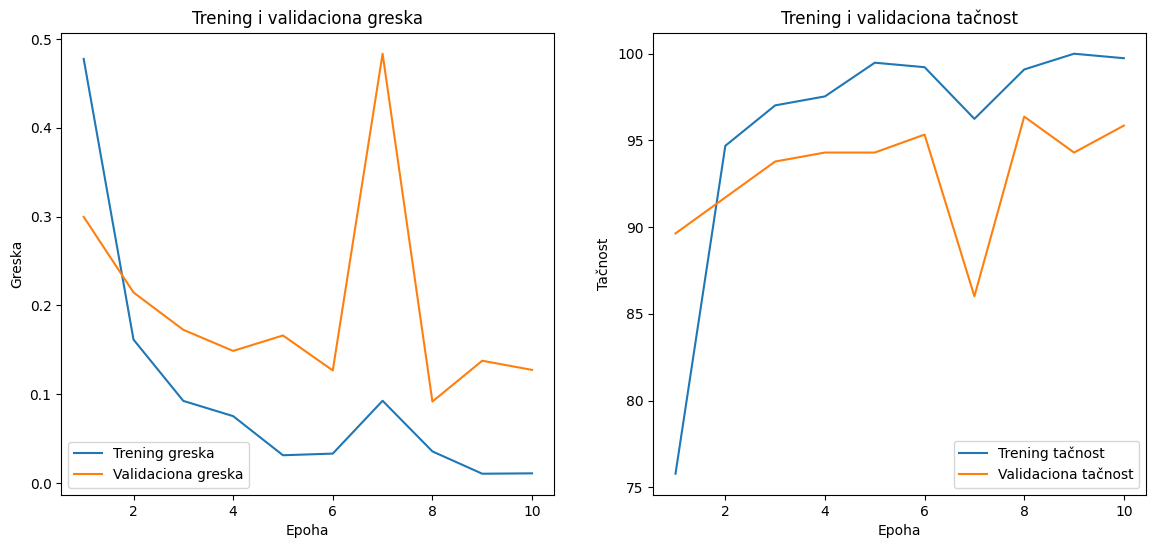

In [18]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Trening greska')
    plt.plot(epochs, val_losses, label='Validaciona greska')
    plt.xlabel('Epoha')
    plt.ylabel('Greska')
    plt.title('Trening i validaciona greska')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Trening tačnost')
    plt.plot(epochs, val_accuracies, label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Trening i validaciona tačnost')
    plt.legend()

    plt.show()


plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### Funkcija za evaluaciju modela i classification report


In [19]:
# Verify number of images in the test set
num_test_images = len(test_loader.dataset)
print(f'Number of images in test set: {num_test_images}')

# Check the number of images processed in the classification report
def evaluate_model_with_report(model, test_loader, device, class_names):
    model.eval()  # Set model to evaluation mode
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            # Add labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate accuracy and loss
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct_test / total_test
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.2f}%')
    
    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

# Evaluate model with report
class_names = original_dataset.classes  # Get class names from training data
evaluate_model_with_report(model, test_loader, device, class_names)

Number of images in test set: 20
Test loss: 0.4395, Test accuracy: 85.00%

Classification Report:
              precision    recall  f1-score   support

   def_front       1.00      0.73      0.84        11
    ok_front       0.75      1.00      0.86         9

    accuracy                           0.85        20
   macro avg       0.88      0.86      0.85        20
weighted avg       0.89      0.85      0.85        20



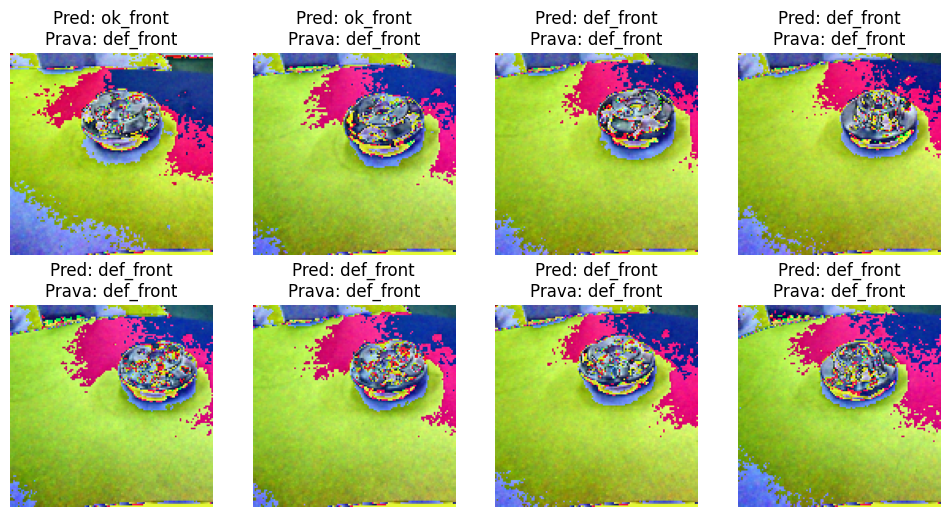

In [20]:
# Prikazivanje nekih test slika sa predikcijama
def show_predictions(model, dataloader, class_names, device):
    model.eval()  # Stavljanje modela u mod za evaluaciju
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)  # Predikcija klase
    
    fig = plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        ax = plt.subplot(2, 4, idx+1)
        img = transforms.ToPILImage()(images[idx].cpu())  # Konverzija tenzora u sliku
        ax.imshow(img)
        ax.set_title(f'Pred: {class_names[preds[idx]]}\nPrava: {class_names[labels[idx]]}')
        ax.axis('off')
    plt.show()

# Prikaz predikcija
class_names = original_dataset.classes
show_predictions(model, test_loader, class_names, device)
